In [1]:
from vnstock import *
from function import *
from operators import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests

##### VN30

In [44]:
x='2023-02-14'
ticket = ['ACB', 'BCM', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 'MBB', 'MSN', 'MWG', 'NVL', 'PDR', 'PLX', 'POW', 'SAB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIB', 'VIC', 'VJC', 'VNM', 'VPB', 'VRE']
frame = []
for i in ticket:
    a = stock_historical_data(symbol=i, 
                            start_date=x, 
                            end_date=x)    
    a["ticker"] = i
    frame.append(a)
    
q = pd.concat(frame)
close= q.pivot_table(values="Close", columns="ticker", index="TradingDate")
high= q.pivot_table(values="High", columns="ticker", index="TradingDate")
low= q.pivot_table(values="Low", columns="ticker", index="TradingDate")
open= q.pivot_table(values="Open", columns="ticker", index="TradingDate")
volume = q.pivot_table(values="Volume", columns="ticker", index="TradingDate")

In [ ]:
close= close.to_csv("Data/close.csv",mode="a",header=False)
high= high.to_csv("Data/high.csv",mode="a",header=False)
low= low.to_csv("Data/low.csv",mode="a",header=False)
open= open.to_csv("Data/open.csv",mode="a",header=False)
volume= volume.to_csv("Data/volume.csv",mode="a",header=False)

In [2]:
close= pd.read_csv("Data/close.csv",index_col="TradingDate")
close.index = pd.to_datetime(close.index)
high= pd.read_csv("Data/high.csv",index_col="TradingDate")
high.index = pd.to_datetime(high.index)
low= pd.read_csv("Data/low.csv",index_col="TradingDate")
low.index = pd.to_datetime(low.index)
open= pd.read_csv("Data/open.csv",index_col="TradingDate")
open.index = pd.to_datetime(open.index)
volume= pd.read_csv("Data/volume.csv",index_col="TradingDate")
volume.index = pd.to_datetime(open.index)

returns = close.pct_change()

### Prob weight model

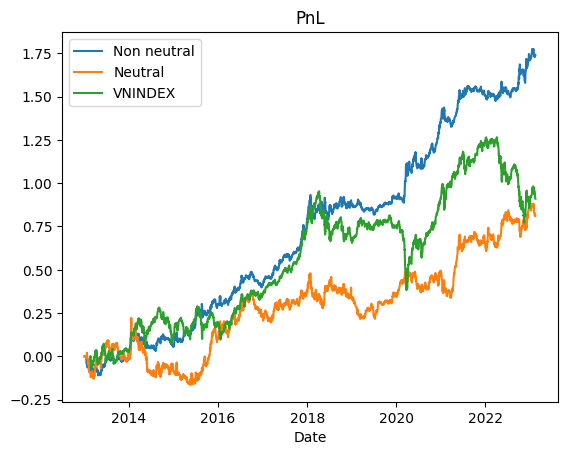

In [5]:
alpha = prob_weights(close,10)

w = weights(alpha,neutrali=0)
w1 = weights(alpha,neutrali=1)

a = Simresult(w,returns=returns)
a.plot_pnl("Non neutral")

b = Simresult(w1,returns=returns)
b.plot_pnl("Neutral")

plot_vnindex()

In [7]:
w1.sum(axis=1)

TradingDate
2013-01-02    0.000000e+00
2013-01-03    0.000000e+00
2013-01-04    0.000000e+00
2013-01-07    0.000000e+00
2013-01-08    0.000000e+00
                  ...     
2023-02-07    2.151057e-16
2023-02-08    1.457168e-16
2023-02-09    4.857226e-17
2023-02-10   -2.105966e-01
2023-02-13   -2.403473e-01
Length: 2522, dtype: float64

In [7]:
a.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.173706,1.249533,0.376661,0.848555,461.173615


In [6]:
b.get_summary()

,Return,Sharpe,Turnover,Fitness,Margin
TradingDate,,,,,
2013,-0.003629,-0.034341,0.416824,-0.003204,-8.706044
2014,0.058547,0.454120,0.426760,0.168202,137.190193
2015,0.250234,1.965235,0.390751,1.572671,640.393363
2016,0.115262,1.016569,0.409560,0.539288,281.428092
2017,0.368112,4.034072,0.339083,4.203204,1085.609287
2018,0.095185,0.526971,0.366377,0.268601,259.800803
2019,0.049986,0.730352,0.397657,0.258943,125.702440
2020,0.445966,2.378540,0.346717,2.697577,1286.254459
2021,0.136777,0.925160,0.356409,0.573125,383.764155


In [13]:
w1.iloc[-1,:].sort_values(ascending=False)

PLX    0.200000
SAB    0.200000
VCB    0.200000
VHM    0.062634
PDR    0.045957
VIC    0.027435
VPB    0.013476
GVR    0.008527
MSN    0.001624
FPT   -0.000229
MBB   -0.008426
VJC   -0.013777
SSI   -0.016025
VNM   -0.021402
BCM   -0.029417
VIB   -0.030725
ACB   -0.031468
BVH   -0.032452
TCB   -0.042604
POW   -0.047556
HPG   -0.048274
MWG   -0.048676
VRE   -0.056984
NVL   -0.061210
STB   -0.068330
TPB   -0.071852
CTG   -0.086133
GAS   -0.089166
HDB   -0.091813
BID   -0.103483
Name: 2023-02-13 00:00:00, dtype: float64

### Markowitz model

In [3]:
mark = marko_weights(close,lag=10)

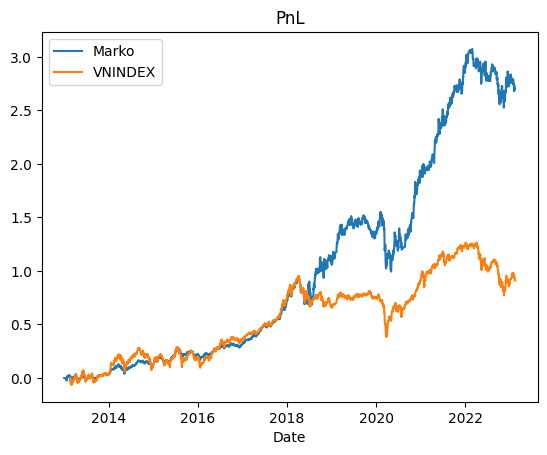

In [4]:
a = Simresult(mark,returns=close.pct_change())
a.plot_pnl("Marko")

plot_vnindex()

In [5]:
a.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.269356,0.876712,0.098561,1.286962,2732.883822


In [6]:
mark.iloc[-1,:].sort_values(ascending=False)

VCB    1.000000e+00
NVL    5.833212e-16
PLX    5.012560e-16
VIB    4.432995e-16
POW    4.278986e-16
MSN    3.215095e-16
SAB    2.900213e-16
MWG    2.266368e-16
FPT    2.230720e-16
VHM    1.655467e-16
VIC    1.044592e-16
GAS    7.632670e-17
HDB    5.358006e-17
VJC    5.536256e-18
STB    0.000000e+00
VNM    0.000000e+00
VPB    0.000000e+00
TPB    0.000000e+00
TCB    0.000000e+00
ACB    0.000000e+00
SSI    0.000000e+00
BCM    0.000000e+00
PDR    0.000000e+00
MBB    0.000000e+00
HPG    0.000000e+00
GVR    0.000000e+00
CTG    0.000000e+00
BVH    0.000000e+00
BID    0.000000e+00
VRE    0.000000e+00
Name: 2023-02-14 00:00:00, dtype: float64

In [103]:
a.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.270532,0.880428,0.0994,1.452477,2721.637832


### alpha1 = close-ts_product(close,2)^0.5

In [3]:
alpha4 = close-ts_product(close,2)**0.5

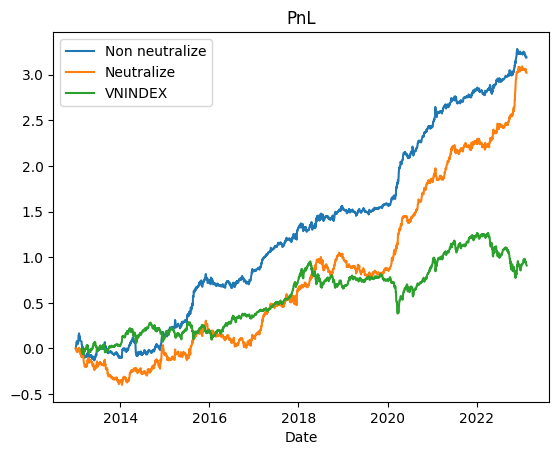

In [4]:
w = weights(alpha4,neutrali=0)
w1 =weights(alpha4,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

plot_vnindex()

In [5]:
a.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.31883,1.775482,1.331533,0.868801,239.445986


In [5]:
a.get_summary()

,Return,Sharpe,Turnover,Fitness,Margin
TradingDate,,,,,
2013,-0.098033,-0.529439,1.276389,-0.146727,-76.804928
2014,0.229845,1.309484,1.287131,0.553358,178.571520
2015,0.622227,2.969580,1.243514,2.100604,500.378276
2016,0.103313,0.649422,1.295763,0.183375,79.731055
2017,0.476558,3.319054,1.246933,2.051873,382.183888
2018,0.210365,0.961280,1.371960,0.376414,153.331701
2019,0.056355,0.513905,1.415318,0.102547,39.817988
2020,0.842759,4.331601,1.320395,3.460574,638.262681
2021,0.411932,2.371984,1.389048,1.291712,296.556870


In [6]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.301959,1.411115,2.430707,0.497359,124.226695


In [6]:
b.get_summary()

,Return,Sharpe,Turnover,Fitness,Margin
TradingDate,,,,,
2013,-0.359061,-1.754053,2.312435,-0.691181,-155.274046
2014,0.299167,1.430793,2.311373,0.514753,129.432677
2015,0.249485,0.983844,2.235507,0.328670,111.600973
2016,-0.066890,-0.354102,2.317505,-0.060159,-28.863083
2017,0.535188,2.388655,2.274992,1.158555,235.248277
2018,0.345574,1.514616,2.504258,0.562643,137.994389
2019,-0.122001,-0.746167,2.611006,-0.161292,-46.725579
2020,0.971639,4.840022,2.391936,3.084786,406.214363
2021,0.402777,1.950924,2.588527,0.769566,155.600646


In [20]:
a=ts_sum(1*(open>close),20)/ts_sum(1*(open<close),20)
b=ts_sum(1*(open>close),250)/ts_sum(1*(open<close),250)
alpha6=rank(a/b)

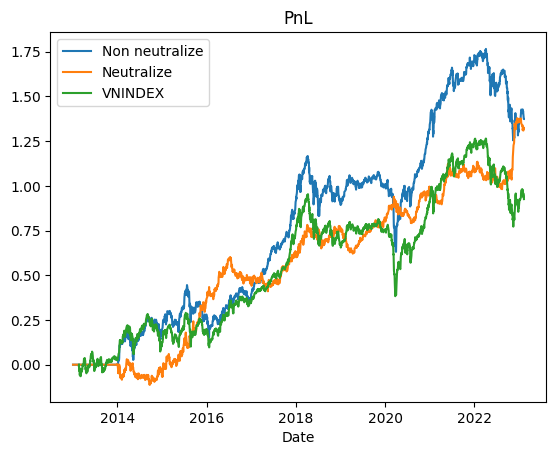

In [21]:
w =weights(alpha6, neutrali=0)
w1 =-1*weights(alpha6,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

plot_vnindex()

In [22]:
a.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.137306,0.704386,0.121601,0.748492,1129.154626


In [23]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.132059,0.910868,0.501322,0.467499,263.420573


### alpha2=ts_zscore(close,2)

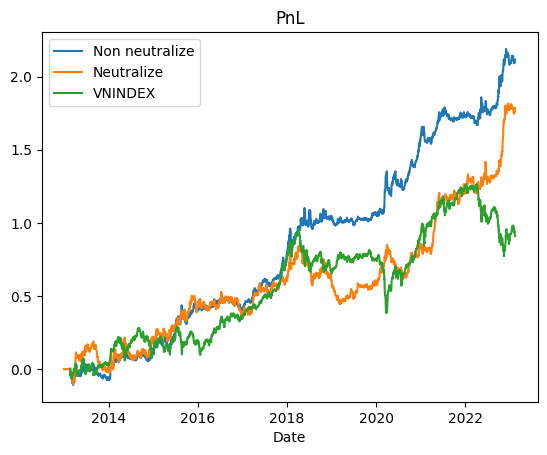

In [7]:
alpha7 = ts_zscore(close,30)
w =weights(alpha7, neutrali=0)
w1 =weights(alpha7,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

plot_vnindex()

In [17]:
a.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.21108,1.233284,0.331917,0.983494,635.941938


In [8]:
a.get_summary()

,Return,Sharpe,Turnover,Fitness,Margin
TradingDate,,,,,
2013,-0.064092,-0.517941,0.334364,-0.226763,-191.683652
2014,0.164754,0.994317,0.348389,0.683772,472.903536
2015,0.308903,1.723217,0.329832,1.667650,936.547681
2016,0.000275,0.002131,0.357286,0.000059,0.769122
2017,0.381386,3.450567,0.326877,3.727181,1166.756143
2018,0.250554,1.128692,0.307966,1.018062,813.575715
2019,0.037460,0.418835,0.331373,0.140820,113.043539
2020,0.518872,2.332487,0.301202,3.061403,1722.672814
2021,0.142905,0.861529,0.335424,0.562337,426.043487


In [9]:
w.iloc[-1,:].sort_values(ascending=False)

VCB    0.043158
SAB    0.037744
BID    0.033565
HDB    0.031564
PLX    0.029452
GAS    0.018974
BCM    0.017420
CTG    0.005394
FPT    0.003142
HPG    0.002381
TPB    0.001542
VRE    0.000596
POW    0.000104
BVH   -0.003832
ACB   -0.004756
STB   -0.008094
VIB   -0.012742
MBB   -0.020338
SSI   -0.031250
MWG   -0.031469
MSN   -0.035352
TCB   -0.039177
GVR   -0.042732
VIC   -0.050364
VNM   -0.054764
VJC   -0.074882
VHM   -0.078724
VPB   -0.081651
PDR   -0.096943
NVL   -0.107893
Name: 2023-02-13 00:00:00, dtype: float64

In [5]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.176338,0.916854,0.733388,0.449579,240.442761


### Merge alpha

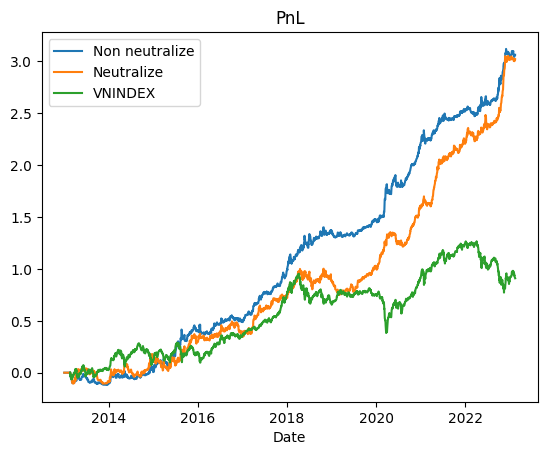

In [8]:
alpha = (0.4*alpha7+0.4*ts_zscore(close,2))
w =weights(alpha, neutrali=0)
w1 =weights(alpha,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

m=get_index_series(index_code='VNINDEX', time_range='TenYears')
m["i"]=pd.to_datetime(m["tradingDate"])
plt.plot(m["i"],np.cumsum(m["indexValue"].pct_change()), label="VNINDEX")
plt.legend()

In [12]:
a.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.305984,1.804652,0.640808,1.247037,477.497713


In [11]:
a.get_summary()

,Return,Sharpe,Turnover,Fitness,Margin
TradingDate,,,,,
2013,-0.104503,-1.033975,0.236940,-0.686681,-441.052078
2014,0.111797,0.738517,0.393747,0.393520,283.931050
2015,0.401127,2.277996,0.609586,1.847890,658.030987
2016,0.088494,0.644821,0.613321,0.244936,144.286144
2017,0.495253,4.311215,0.711186,3.597672,696.375989
2018,0.370422,1.686659,0.717977,1.211492,515.925145
2019,0.125631,1.332135,0.724811,0.554605,173.328701
2020,0.739037,3.306999,0.711664,3.369999,1038.463923
2021,0.316544,1.839813,0.787275,1.166616,402.076196


In [9]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.301819,1.617731,1.271235,0.788254,237.421517


In [10]:
b.get_summary()

,Return,Sharpe,Turnover,Fitness,Margin
TradingDate,,,,,
2013,-0.082896,-0.644495,0.337341,-0.319486,-245.732931
2014,0.196360,1.053454,0.700664,0.557682,280.247649
2015,0.188219,0.875880,1.142941,0.355438,164.679222
2016,0.065080,0.396935,1.030453,0.099754,63.156995
2017,0.388779,2.431029,1.453570,1.257256,267.464943
2018,0.140143,0.578509,1.539537,0.174542,91.029299
2019,0.134678,1.019653,1.461513,0.309528,92.149702
2020,0.585210,3.369586,1.583118,2.048687,369.656401
2021,0.606816,3.119563,1.529396,1.964999,396.768458


In [14]:
w1.iloc[-1,:].sort_values(ascending=False)

BCM    0.122681
PLX    0.120221
TPB    0.101100
HPG    0.095713
BVH    0.093404
POW    0.088069
FPT    0.081853
VIB    0.066144
SSI    0.048964
VCB    0.048108
TCB    0.031949
SAB    0.026543
GVR    0.023087
HDB    0.019430
BID    0.017956
GAS    0.014777
ACB   -0.011129
CTG   -0.017678
STB   -0.019221
VRE   -0.029831
MBB   -0.045107
VNM   -0.088973
VIC   -0.089542
VJC   -0.100472
VPB   -0.129716
VHM   -0.132218
PDR   -0.152205
NVL   -0.183908
MSN         NaN
MWG         NaN
Name: 2023-02-14 00:00:00, dtype: float64

In [15]:
save_weights(w1,"14/2/2023")